In [1]:
import torch
import torch.nn as nn
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import u_net.helper as helper

In [2]:
torch.cuda.is_available()

True

## Set up configurations

In [3]:
CSV_FILE = '/home/paperspace/Projects/computer-vision/unet_architecture/train.csv'
DATA_DIR = '/home/paperspace/Projects/computer-vision/unet_architecture/data/'

DEVICE = 'cpu'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,data/Ground_Truth/1.png,data/Training_Images/1.jpg
1,data/Ground_Truth/10.png,data/Training_Images/10.jpg
2,data/Ground_Truth/100.png,data/Training_Images/100.jpg
3,data/Ground_Truth/101.png,data/Training_Images/101.jpg
4,data/Ground_Truth/102.png,data/Training_Images/102.jpg


In [5]:
row = df.iloc[21]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

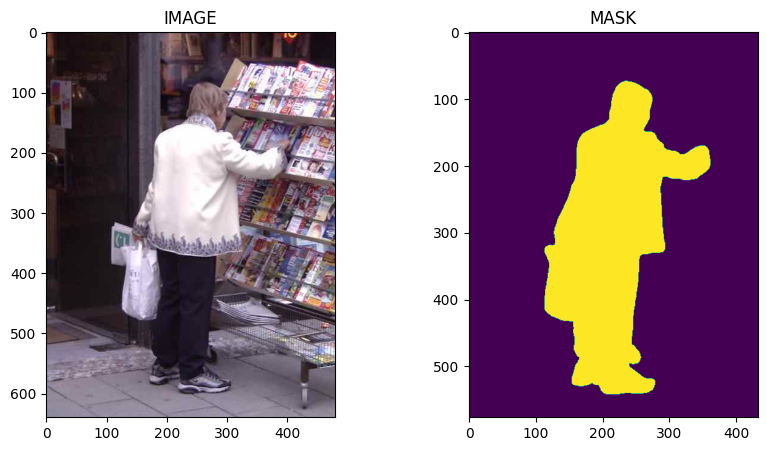

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [7]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

## Augmenting Functions

In [8]:
import albumentations as A

In [9]:
def get_train_augs():
  result = A.Compose(
      [
          A.Resize(IMAGE_SIZE, IMAGE_SIZE),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5)
      ],
      is_check_shapes=False
  )
  return result

def get_valid_augs():
  result = A.Compose(
      [
          A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      ],
      is_check_shapes=False
  )
  return result

## Creating a custom dataset

In [10]:
from torch.utils.data import Dataset

In [11]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [12]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [13]:
print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Validset: {len(validset)}")

Size of Trainset: 232
Size of Validset: 58


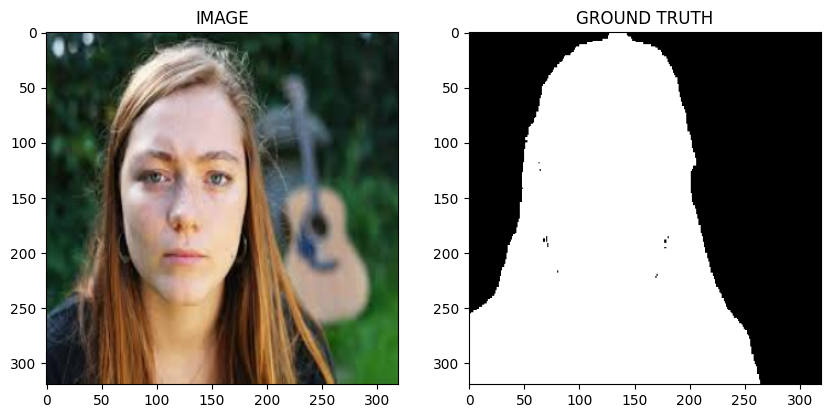

In [14]:
idx = 0
image, mask = trainset[idx]
helper.show_image(image, mask)

## Load dataset into batches

In [15]:
from torch.utils.data import DataLoader

In [16]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [17]:
print(f"total number of batches in trainloader : {len(trainloader)}")
print(f"total number of batches in validloader : {len(validloader)}")

total number of batches in trainloader : 15
total number of batches in validloader : 4


In [18]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


## Create segmentation model

In [19]:
from torch import nn
import u_net.unet as unet

In [20]:
model = unet.UNet()
model.to(DEVICE);

## Creating Train and Validation Functions

In [21]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [22]:
model.train()
total_loss = 0.0
criterion = nn.BCEWithLogitsLoss()
for images, masks in tqdm(trainloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    masks_pred = model(images)
    #loss = criterion(masks_pred.squeeze(1), masks.float())
    #loss += unet.dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


In [28]:
print(masks.size())
print(masks_pred.squeeze(1).size())

torch.Size([8, 1, 320, 320])
torch.Size([8, 3, 132, 132])


In [22]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(data_loader)

## Train Model

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [24]:
train_loss = train_fn(trainloader, model, optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]


TypeError: UNet.forward() takes 2 positional arguments but 3 were given

In [24]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")

  0%|          | 0/15 [00:00<?, ?it/s]


TypeError: UNet.forward() takes 2 positional arguments but 3 were given

## Inference

In [ ]:
idx = 21

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))